# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 150000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (150000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(126359, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

84.23933333333333

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(126357, 10)


1    106326
0     20031
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
Its about time Spanish products started getting their due.. The most famous (rightly so) Spanish cheese, Manchego, is world class, and is really tough to beat.  Try some with some fig cake, or some quince paste, or drizzled with olive oil garnished with rosemary..  Serve with a fino sherry, manzanilla, or any number of red wines (depending on age of cheese), and you are guaranteed a winning combination..  Sliced, melted over a great burger, with a roasted red pepper and a hearty glass of earthy zinfandel = heavenly joy..  Cube and marinate in Spanish olive oil is also a treat... I have had no problems with iGourmet so far, so I can't comment on their customer service - all of my orders have been shipped quickly (1-3 business days

In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.
Its about time Spanish products started getting their due.. The most famous (rightly so) Spanish cheese, Manchego, is world class, and is really tough to beat.  Try some with some fig cake, or some quince paste, or drizzled with olive oil garnished with rosemary..  Serve with a fino sherry, manzanilla, or any number of red wines (depending on age of cheese), and you are guaranteed a winning combination..  Sliced, melted over a great burger, with a roasted red pepper and a hearty glass of earthy zinfandel = heavenly joy..  Cube and marinate in Spanish olive oil is also a treat... I have had no problems with iGourmet so far, so I can't comment on their customer service - all of my orders have been shipped quickly (1-3 business days

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

I love this stuff.  I nuke a mug a milk until it is very hot, drop in 2 of the triangles, stir until the chocolate melts, then froth it with my Aerolatte.  Simple and tasty.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

I grew up reading these Sendak books, and watching the Really Rosie movie that incorporates them, and love them. My son loves them too. I do however, miss the hard cover version. The paperbacks seem kind of flimsy and it takes two hands to keep the pages open.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I love this stuff I nuke a mug a milk until it is very hot drop in 2 of the triangles stir until the chocolate melts then froth it with my Aerolatte Simple and tasty 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 126357/126357 [00:56<00:00, 2252.69it/s]


In [23]:
preprocessed_reviews[1500]

'love stuff nuke mug milk hot drop triangles stir chocolate melts froth aerolatte simple tasty'

# Obtaining the Required DataFrame:

In [24]:
type(preprocessed_reviews)

list

In [25]:
print(final.shape)

(126357, 10)


We obtain a list at the end of all the Preprocessing whereas the data frame that we obtained at the end was named 
'final'. Initially I considered 150K datapoints to work upon which got reduced to approx. 126K datapoints after all 
the text processing and data deduplication.

Out of these 126K datapoints in total we will consider only 100K to be applied to the Decision Tree Algorithm.

In [26]:
final['Preprocessed_Reviews'] = preprocessed_reviews

Basically I have taken the entire list and added the list as a column to the entire dataframe, such that each value
corresponds to a row in the dataframe. 

In [27]:
final.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,1,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",grew reading sendak books watching really rosi...
138699,150517,0006641040,ABW4IC5G5G8B5,kevin clark,0,0,1,1291075200,good for children,"Classic children's book, can't go wrong. I rea...",classic children book not go wrong read kid or...
138698,150516,0006641040,A3OI7ZGH6WZJ5G,"Mary Jane Rogers ""Maedchen""",0,0,1,1293840000,Darling!,"The same author wrote ""Where the Wild Things A...",author wrote wild things carol king wrote grea...
138696,150514,0006641040,A2ONB6ZA292PA,Rosalind Matzner,0,0,1,1313884800,Chicken soup with Rice,It's a great book with adorable illustrations....,great book adorable illustrations true classic...
138695,150513,0006641040,ASH0DZQQF6AIZ,tessarat,0,0,1,1325721600,A classic,I remembered this book from my childhood and g...,remembered book childhood got kids good rememb...


Now I have a total of approx. 126K rows in the dataframe called 'final', of which I will consider only 100K rows to
be applied to the Decision Tree Classifier. Also here you have the Unix Timestamp in the data, which is basically the time when the review was posted. 

This makes it possible to carry out Time Based Split of the data instead of random splitting of the data into Train,
CV and Test Datasets. For Time Based Split I will take the oldest of the reviews as the Training Data, the 
intermediate reviews as the CV data and the latest reviews as the Test data. 

In [28]:
final_TBS = final.sort_values('Time')

In [29]:
final_TBS.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Preprocessed_Reviews
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,witty little book makes son laugh loud recite ...
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,remember seeing show aired television years ag...
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,A sure death for flies,I bought a few of these after my apartment was...,bought apartment infested fruit flies hours tr...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...,really good idea final product outstanding use...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,received shipment could hardly wait try produc...


Now the values are sorted on the basis of Time. We know that by default the values are sorted in ascending order. 

# Further Data Processing :- 

First I will remove all the useless columns from my dataframe. The only columns that we are concerned about here in 
this case are the 'Score' & 'Preprocessed_Reviews' (Without carrying out any Feature Engineering). Remaining columns 
in the dataframe are of no use to us. 

In [30]:
df = final_TBS[['Score','Preprocessed_Reviews']]

In [31]:
df.head()

,Score,Preprocessed_Reviews
138706,1,witty little book makes son laugh loud recite ...
138683,1,remember seeing show aired television years ag...
70688,1,bought apartment infested fruit flies hours tr...
1146,1,really good idea final product outstanding use...
1145,1,received shipment could hardly wait try produc...


# Applying Decision Trees :-

# Obtaining Train, CV and Test Data :-

In [32]:
Dec_treedf = df[:100000]

Basically we are taking a total of 100K reviews for the model. Since I am carrying out Time Based Splitting into 
Train, CV and Test datasets, I will split them in 70:10:20 ratio respectively. 
        
        So, # of Datapoints in Train data = 70,000 
            # of Datapoints in CV data = 10,000
            # of Datapoints in Test data = 20,000

In [33]:
Tr_dectree_df = Dec_treedf[:70000]
CV_dectree_df = Dec_treedf[70000:80000]
Te_dectree_df = Dec_treedf[80000:100000]

In [34]:
Tr_dectree_df.shape

(70000, 2)

In [35]:
CV_dectree_df.shape

(10000, 2)

In [36]:
Te_dectree_df.shape

(20000, 2)

Yes everything is working as expected: There are 70K points in the Training data, 10K points in the CV data and 20K
points in the Test data.

Now we can split the data as features in X and the class label in Y.

In [37]:
X_DTTrain = Tr_dectree_df['Preprocessed_Reviews']
Y_DTTrain = Tr_dectree_df['Score']

X_DTCV = CV_dectree_df['Preprocessed_Reviews']
Y_DTCV = CV_dectree_df['Score']

X_DTTest = Te_dectree_df['Preprocessed_Reviews']
Y_DTTest = Te_dectree_df['Score']

In [38]:
Y_DTTrain.value_counts()

1    59861
0    10139
Name: Score, dtype: int64

In [39]:
Y_DTCV.value_counts()

1    8241
0    1759
Name: Score, dtype: int64

In [40]:
Y_DTTest.value_counts()

1    16305
0     3695
Name: Score, dtype: int64

As expected, this is an imbalanced real world dataset. 

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


# [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


# [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2V

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5.1] SET 1 : Applying Decision Trees on BOW :-

In [41]:
count_vect = CountVectorizer()
count_vect.fit(X_DTTrain) #Again the fit function is applied only on the Train data. 

#fit internally stores the parameters that will be used for transforming the data from the text to a numerical vector

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [42]:
X_DTTrain_BOW = count_vect.transform(X_DTTrain)
X_DTCV_BOW = count_vect.transform(X_DTCV)
X_DTTest_BOW = count_vect.transform(X_DTTest)

In [43]:
print("Shapes before the BOW Vectorization was carried out:")

print(X_DTTrain.shape,Y_DTTrain.shape)
print(X_DTCV.shape,Y_DTCV.shape)
print(X_DTTest.shape,Y_DTTest.shape)

print("*"*100)

print("Shapes after the BOW Vectorization was carried out:")

print(X_DTTrain_BOW.shape,Y_DTTrain.shape)
print(X_DTCV_BOW.shape,Y_DTCV.shape)
print(X_DTTest_BOW.shape,Y_DTTest.shape)

Shapes before the BOW Vectorization was carried out:
(70000,) (70000,)
(10000,) (10000,)
(20000,) (20000,)
****************************************************************************************************
Shapes after the BOW Vectorization was carried out:
(70000, 49207) (70000,)
(10000, 49207) (10000,)
(20000, 49207) (20000,)


# Hyperparameter Tuning on the BOW Representation :- 

Here we care about 2 hyperparameters :-
* "max_depth", which we would be considering in the range :- { [4,6, 8, 9,10,12,14,17] }
* "min_samples_split", which we would be considering in the range :- { [2,10,20,30,40,50] }

We can easily apply GridSearchCV in this case since we are only focused on 2 Hyperparameters. If we had to obtain the best values for a lot of hyperparameters, GridSearchCV won't have been the best option considering its
time complexity.

In [44]:
depth_hyperparameter = [4,6,8,9,10,12,14,17]
samples_hyperparameter = [2,10,20,30,40,50]

Here we have generated a list with the required values of the 2 hyperparameters. The necessary 
packages are imported as follows:- 

In [45]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np
import warnings

However in this case for the Decision Tree Classification there is no need to carry out Standardization because we do 
not have any hyperplane in consideration over here unlike the other algorithms that we have encountered previously.

<b> <font color="black"> Function to obtain the DataFrame for the AUC Metric Calculation from the Training Data  :- </font> </b>

In [46]:
def train_heatmap(X_Train,Y_Train):

    df1 = []
    df2 = []
    Train_AUC = []

    for i in depth_hyperparameter:
        for j in samples_hyperparameter:
            df1.append(i)
            df2.append(j)
        
            Train_model = DecisionTreeClassifier(criterion='gini',splitter='best',class_weight='balanced',
                                         min_samples_split=j,max_depth=i)
            Train_model.fit(X_Train,Y_Train)
        
            Y_Train_pred = Train_model.predict_proba(X_Train)[:,1]
            Train_AUC.append(roc_auc_score(Y_Train,Y_Train_pred))  
            
    train_data = {'max_depth':df1,'min_samples_split':df2,'AUC_Score':Train_AUC}
    train_dataframe = pd.DataFrame(train_data)
    train_dataframe = train_dataframe.pivot("max_depth","min_samples_split","AUC_Score")
            
    return train_dataframe            

<b> <font color="black"> Function to obtain the DataFrame for the AUC Metric Calculation from the CV Data  :- </font> </b>

In [47]:
def cv_heatmap(X_Train,Y_Train,X_CV,Y_CV):

    df3 = []
    df4 = []
    CV_AUC = []

    for i in depth_hyperparameter:
        for j in samples_hyperparameter:
            df3.append(i)
            df4.append(j)
        
            CV_model = DecisionTreeClassifier(criterion='gini',splitter='best',class_weight='balanced',
                                         min_samples_split=j,max_depth=i)
            CV_model.fit(X_Train,Y_Train)
        
            Y_CV_pred = CV_model.predict_proba(X_CV)[:,1]
            CV_AUC.append(roc_auc_score(Y_CV,Y_CV_pred))  
            
    cv_data = {'max_depth':df3,'min_samples_split':df4,'AUC_Score':CV_AUC}
    cv_dataframe = pd.DataFrame(cv_data)
    cv_dataframe = cv_dataframe.pivot("max_depth","min_samples_split","AUC_Score")
            
    return cv_dataframe            

  What I have carried out in both of these functions is as follows :-
* We have already initialized 2 Lists for each of the 2 Hyperparameters :- "depth_hyperparameter" for the parameter "max_depth" and "samples_hyperparameter" for the parameter "min_samples_split" in the Decision Tree Classifier. 
* Now basically we are trying to obtain a dataframe with all the possible combinations of the 2 Hyperparameters to obtain the corresponding Heatmap with the AUC Scores for that particular combination shown as an annotation in the Heatmap.
* Remember that even in the case to obtain the Cross Validation DataFrame, we are supposed to fit() only on the Train dataset. We give column headers to each of the columns in the DataFrame which we consequently pivot to obtain the data in the dataframe in the required format so that the Heatmap is plotted as expected. 
* Basically, at the end of calling each of these functions, we obtain the corresponding dataframe, whether that be for the Training Data or the CV Data. 

<b> <font color="black"> Function to plot the Seaborn HeatMaps for the Train & CV Dataframes obtained  :- </font> </b>

In [48]:
def plot_heatmaps(train_df,cv_df):
    fig, ax = plt.subplots(figsize=(30,5))

    plt.subplot(1, 3, 1)
    sns.heatmap(train_df, annot=True,cmap='RdYlGn',linewidths=0.5,annot_kws={"size": 13})
    plt.xlabel('Min_samples_split',fontsize=12)
    plt.ylabel('Max_Depth',fontsize=12)
    plt.title("Training Data AUC Score Heatmap",fontsize=15)

    plt.subplot(1, 3, 2)
    sns.heatmap(cv_df, annot=True,cmap='RdYlGn',linewidths=0.5,annot_kws={"size": 13})
    plt.xlabel('Min_samples_split',fontsize=12)
    plt.ylabel('Max_Depth',fontsize=12)
    plt.title("CV Data AUC Score Heatmap",fontsize=15)

    plt.show()

* In the function above, we are plotting the Seaborn HeatMaps for the Train and CV Dataframes next to each other as subplots for easier comparison of the AUC Values. 
* Note that we could have carried out the same with the help of a 3-D plot of the 2 Hyperparameters. However, the issue with this approach is the fact that it becomes difficult to visualise the right combination of the 2 Hyperparameters. 

* Again, our aim in choosing the Best Hyperparameters is the same as before :
 The AUC Value on the CV Dataset be the maximum and the gap between the Train and CV AUC values be low, which we obtain with the help of the Heatmaps obtained below. The same is confirmed by carrying out the GridSearchCV with 10-fold Cross Validation and obtaining the best_estimator_.

<b> <font color="black"> Calling the Different Functions to obtain the Train and CV Dataframes and Obtaining the Seaborn HeatMaps for them :- </font> </b>

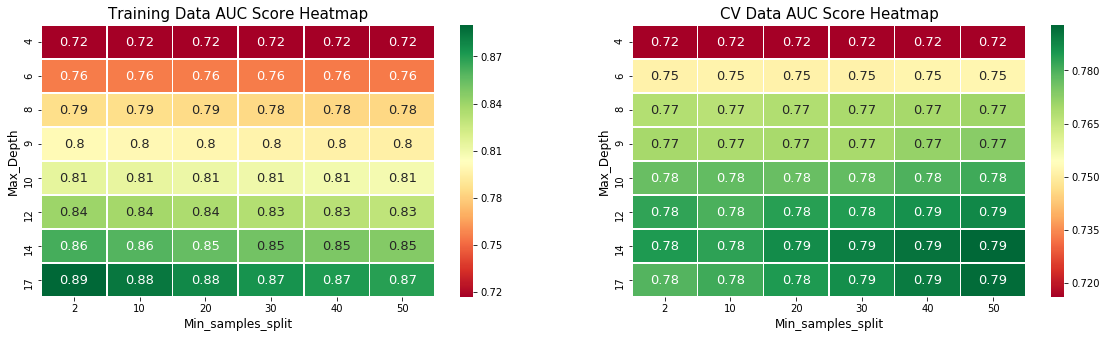

In [52]:
BOW_Train_df = train_heatmap(X_DTTrain_BOW,Y_DTTrain)
BOW_CV_df = cv_heatmap(X_DTTrain_BOW,Y_DTTrain,X_DTCV_BOW,Y_DTCV)
plot_heatmaps(BOW_Train_df,BOW_CV_df)

With the Seaborn Heatmaps obtained, we see that :
* The maximum AUC Value on the CV Heatmap is 0.79, and the minimum AUC Value on the Train Heatmap for the same combination is 0.83. 
* Therefore the Best Combination of Max_Depth and Min_samples_split for the BOW Featurization is either of the following: 

Max_Depth=17.
Min_samples_split= 50 or 40 or 30.

* Therefore the best of these values is obtained by GridSearchCV below.

In [53]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

parameters= [{'max_depth':depth_hyperparameter, 'min_samples_split':samples_hyperparameter}]
model1 = DecisionTreeClassifier(criterion='gini',splitter='best',class_weight='balanced')
    
DT_BOW = GridSearchCV(model1,parameters,scoring='roc_auc',cv=10)
DT_BOW.fit(X_DTTrain_BOW,Y_DTTrain)
    
print(DT_BOW.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=17, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Therefore obtaining the Best Hyperparameters of the model after carrying out Hyperparameter tuning via GridSearchCV, we obtain the following Best values :-
* max_depth = 17
* min_samples_split = 50

# Testing with the Test Data on the BOW Representation:-

In [68]:
BOW_Test = DecisionTreeClassifier(criterion='gini',splitter='best',class_weight='balanced',max_depth=17,
                                  min_samples_split=50)
BOW_Test.fit(X_DTTrain_BOW,Y_DTTrain)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=17, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Therefore here we are basically creating a model (to Test the model on the Test Data) by applying the Best values of the Hyperparameters hence obtained.

In [55]:
Y_DTTrain.shape

(70000,)

In [56]:
print(X_DTTrain_BOW.shape)

(70000, 49207)


In [57]:
print(Y_DTTest.shape)

(20000,)


In [58]:
print(X_DTTest_BOW.shape)

(20000, 49207)


In [59]:
from sklearn.metrics import roc_curve, auc 

train_fpr1,train_tpr1,threshold = roc_curve(Y_DTTrain,BOW_Test.predict_proba(X_DTTrain_BOW)[:,1])
test_fpr1,test_tpr1,threshold = roc_curve(Y_DTTest,BOW_Test.predict_proba(X_DTTest_BOW)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

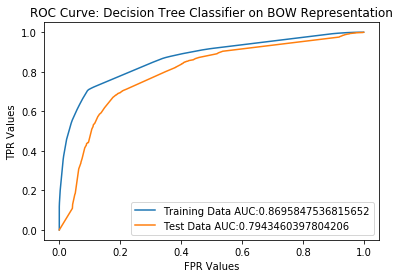

In [60]:
import matplotlib.pyplot as plt

plt.plot(train_fpr1,train_tpr1,label ='Training Data AUC:' + str(auc(train_fpr1,train_tpr1)))
plt.plot(test_fpr1,test_tpr1,label = 'Test Data AUC:' + str(auc(test_fpr1,test_tpr1)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Decision Tree Classifier on BOW Representation')

plt.grid(False)
plt.show()

In [61]:
Y_Train_pred1 = BOW_Test.predict_proba(X_DTTrain_BOW)[:,1]
Y_Test_pred1 = BOW_Test.predict_proba(X_DTTest_BOW)[:,1]

<b> <font color="black"> Function to Obtain the Best Threshold & Predictions:- </font> </b>

In [62]:
def matrixpredict(data,thresholds,tpr,fpr):   
    matrixpredict.best_tradeoff = tpr*(1-fpr)
    matrixpredict.ideal_threshold = thresholds[matrixpredict.best_tradeoff.argmax()]
 
    predictions=[]
    
    for i in data:
        if i>= matrixpredict.ideal_threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

<b> <font color="black"> Function to Plot the Training Confusion Matrix HeatMap:- </font> </b>

In [63]:
import seaborn as sns

def plottrainmatrix (train_matrix):
    sns.set_style("whitegrid")
    
    labels = [0,1]
    
    print("-"*20, "Training Confusion Matrix", "-"*20)
    print(" ")
    print("The Training Data Confusion Matrix is as follows:")
    print(" ")
    print("The maximum value of tpr*(1-fpr) :", max(matrixpredict.best_tradeoff))
    print("Threshold for Maximum Value of tpr*(1-fpr) :",round(matrixpredict.ideal_threshold,3))
   
    plt.figure(figsize=(10,7))
    
    sns.heatmap(train_matrix,
                annot=True, cmap="YlGnBu",fmt=".0f", xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 15})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()   

<b> <font color="black"> Function to Plot the Test Confusion Matrix HeatMap:- </font> </b>

In [64]:
import seaborn as sns

def plottestmatrix (test_matrix):
    labels = [0,1]
    
    print("-"*20, "Test Data Confusion Matrix", "-"*20)
    print(" ")
    print("The Test Data Confusion Matrix is as follows:")
    print(" ")
    print("The maximum value of tpr*(1-fpr) :", max(matrixpredict.best_tradeoff))
    print("Threshold for Maximum Value of tpr*(1-fpr) :",round(matrixpredict.ideal_threshold,3))
   
    plt.figure(figsize=(10,7))
    
    sns.heatmap(test_matrix,annot=True, cmap="YlGnBu",fmt=".0f", xticklabels=labels, 
                yticklabels=labels,annot_kws={"size": 15})
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()     

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6416039417246199
Threshold for Maximum Value of tpr*(1-fpr) : 0.444


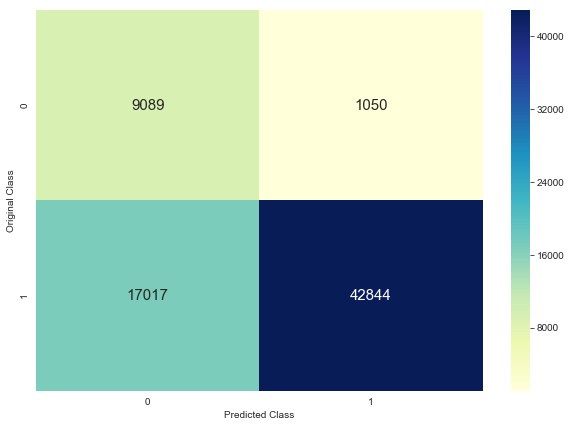

In [65]:
BOW_Train = confusion_matrix(Y_DTTrain,matrixpredict(Y_Train_pred1,threshold,train_tpr1,train_fpr1))
plottrainmatrix(BOW_Train)

Accuracy on the Training Data => (42844+9089)/70000 = 74.19%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.5574729685598322
Threshold for Maximum Value of tpr*(1-fpr) : 0.404


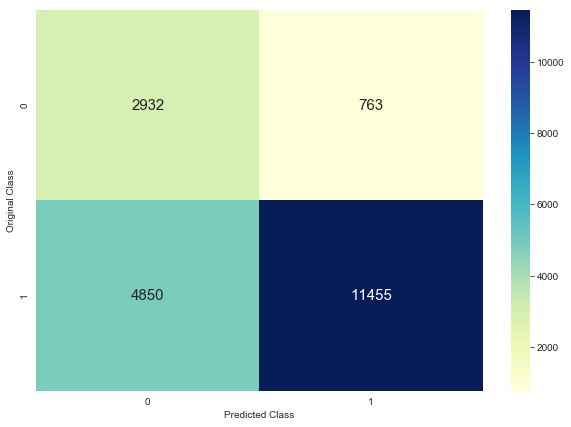

In [66]:
BOW_Test = confusion_matrix(Y_DTTest,matrixpredict(Y_Test_pred1,threshold,test_tpr1,test_fpr1))
plottestmatrix(BOW_Test)

Accuracy on the Test Data => (11443+2931)/20000 = 71.93%

# [5.1.1] Top 20 Important Features with Decision Tree Implementation & BOW Featurization :-

In [69]:
BOW_feature_names = count_vect.get_feature_names()
BOW_feature_importances = BOW_Test.feature_importances_
BOW_feature_importances_sorted = np.argsort(BOW_feature_importances)
BOW_feature_importances_reverse = np.flip(BOW_feature_importances_sorted)

In [158]:
print("The Top 20 Important Features with BOW Featurization and their corresponding feature " 
      "importances are as follows:")
print("="*100)
for i in BOW_feature_importances_reverse[:20]:
    print(BOW_feature_names[i],"\t", '--->',np.round(BOW_feature_importances[i],3))

The Top 20 Important Features with BOW Featurization and their corresponding feature importances are as follows:
not 	 ---> 0.174
great 	 ---> 0.103
best 	 ---> 0.054
delicious 	 ---> 0.049
love 	 ---> 0.035
perfect 	 ---> 0.032
good 	 ---> 0.029
loves 	 ---> 0.028
bad 	 ---> 0.024
disappointed 	 ---> 0.019
nice 	 ---> 0.018
favorite 	 ---> 0.017
excellent 	 ---> 0.015
wonderful 	 ---> 0.015
unfortunately 	 ---> 0.014
easy 	 ---> 0.013
thought 	 ---> 0.012
money 	 ---> 0.011
highly 	 ---> 0.009
awful 	 ---> 0.008


# [5.1.2] Graphviz visualization of Decision Tree on BOW Featurization :-

In [72]:
from sklearn import tree
BOW_tree = tree.export_graphviz(decision_tree=BOW_Test,max_depth=3,feature_names = BOW_feature_names,
                               filled = True)

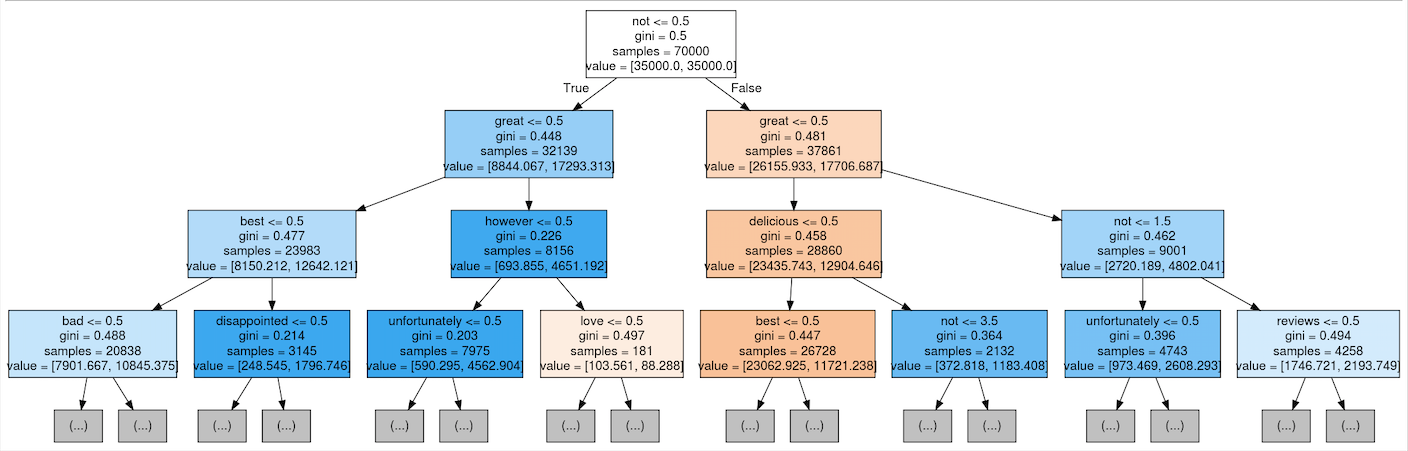

In [73]:
from IPython.display import Image
Image(filename='BOW_DT_filled.png')

Following is what I have carried out in this scenario :-
* Initially the variable BOW_Tree is declared to be equal to the value obtained when export_graphviz is called. Here, 'decision_tree' parameter has the 'BOW_Test' ie the decision tree where the Hyperparameter Tuning has been successfully carried out.
* Then 'feature_names' parameter has been provided with the variable called 'BOW_feature_names' which has all the feature names obtained by the BOW Representation. Similarly, for the ease of visualization, max_depth has been provided only with a value of 3. 
* Also the parameter called 'filled' has been set a Boolean Value of 'True' :- This basically means that when it's set to 'True' it paints nodes to indicate majority class for classification and the extremity of values in case of regression. 
* Now, since we have not assigned any particular value to the parameter 'out_file' it takes the default value of String and returns a String output. Now, when this output is passed to the following website link :- 'http://webgraphviz.com/', we obtain the HTML link of the Decision Tree. 
* Now this HTML Link is converted to a png image online, downloaded and then copied to the Current Working Directory in order to be uploaded to the Jupyter Notebook with the help of the code block stated above.

# [5.2] SET 2 : Applying Decision Trees on TFIDF :-

In [74]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(X_DTTrain)

# Again fit is carried out only on the Training data. fit() internally stores the parameters that will be used to 
#convert the Text to a numerical vector. 

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [75]:
X_DTTrain_TFIDF = tf_idf_vect.transform(X_DTTrain)
X_DTCV_TFIDF = tf_idf_vect.transform(X_DTCV)
X_DTTest_TFIDF = tf_idf_vect.transform(X_DTTest)

In [76]:
print("Shapes before the TFIDF Vectorization was carried out:")

print(X_DTTrain.shape,Y_DTTrain.shape)
print(X_DTCV.shape,Y_DTCV.shape)
print(X_DTTest.shape,Y_DTTest.shape)

print("="*100)

print("Shapes after the TFIDF Vectorization was carried out:")

print(X_DTTrain_TFIDF.shape,Y_DTTrain.shape)
print(X_DTCV_TFIDF.shape,Y_DTCV.shape)
print(X_DTTest_TFIDF.shape,Y_DTTest.shape)

Shapes before the TFIDF Vectorization was carried out:
(70000,) (70000,)
(10000,) (10000,)
(20000,) (20000,)
Shapes after the TFIDF Vectorization was carried out:
(70000, 41297) (70000,)
(10000, 41297) (10000,)
(20000, 41297) (20000,)


# Hyperparameter Tuning on the TFIDF Representation :- 

Again, all that we care about are 2 hyperparameters :-
* "max_depth", which we would be considering in the range :- { [4,6, 8, 9,10,12,14,17] }
* "min_samples_split", which we would be considering in the range :- { [2,10,20,30,40,50] }

However in this case for the Decision Tree Classification there is no need to carry out Standardization because we do 
not have any hyperplane in consideration over here unlike the other algorithms that we have encountered previously.

<b> <font color="black"> Calling the Different Functions to obtain the Train and CV Dataframes and Obtaining the Seaborn HeatMaps for them :- </font> </b>

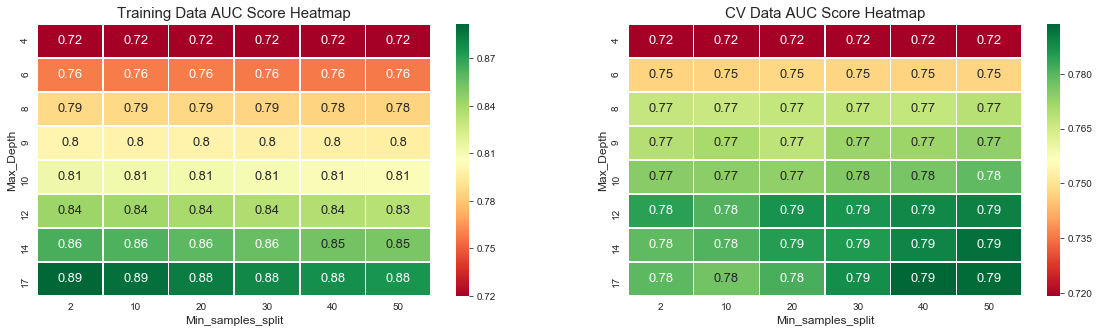

In [77]:
TFIDF_Train_df = train_heatmap(X_DTTrain_TFIDF,Y_DTTrain)
TFIDF_CV_df = cv_heatmap(X_DTTrain_TFIDF,Y_DTTrain,X_DTCV_TFIDF,Y_DTCV)
plot_heatmaps(TFIDF_Train_df,TFIDF_CV_df)

With the Seaborn Heatmaps obtained, we see that :
* The maximum AUC Value on the CV Heatmap is 0.79, and the minimum AUC Value on the Train Heatmap for the same combination is 0.88. 
* Therefore the Best Combination of Max_Depth and Min_samples_split for the BOW Featurization is either of the following: 

Max_Depth=12 or 17.
Min_samples_split= 50 or 40 or 30.

* Therefore the best of these values is obtained by GridSearchCV below.

In [78]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

model2 = DecisionTreeClassifier(criterion='gini',splitter='best',class_weight='balanced')
    
DT_TFIDF = GridSearchCV(model2,parameters,scoring='roc_auc',cv=10)
DT_TFIDF.fit(X_DTTrain_TFIDF,Y_DTTrain)
    
print(DT_TFIDF.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=17, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Therefore, according to the Hyperparameter Tuning and obtaining the Best Hyperparameters of the model after carrying out Hyperparameter tuning via GridSearchCV, we obtain the following Best values :-
* max_depth = 17
* min_samples_split = 50

# Testing with the Test Data on the TFIDF Representation:-

In [113]:
TFIDF_Test = DecisionTreeClassifier(criterion='gini',splitter='best',class_weight='balanced',max_depth=17,
                                  min_samples_split=50)
TFIDF_Test.fit(X_DTTrain_TFIDF,Y_DTTrain)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=17, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Therefore here we are basically creating a model (to Test the model on the Test Data) by applying the Best values of the Hyperparameters hence obtained.

In [114]:
Y_DTTrain.shape

(70000,)

In [115]:
print(X_DTTrain_TFIDF.shape)

(70000, 41297)


In [116]:
print(Y_DTTest.shape)

(20000,)


In [117]:
print(X_DTTest_TFIDF.shape)

(20000, 41297)


In [118]:
from sklearn.metrics import roc_curve, auc 

train_fpr2,train_tpr2,threshold = roc_curve(Y_DTTrain,TFIDF_Test.predict_proba(X_DTTrain_TFIDF)[:,1])
test_fpr2,test_tpr2,threshold = roc_curve(Y_DTTest,TFIDF_Test.predict_proba(X_DTTest_TFIDF)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

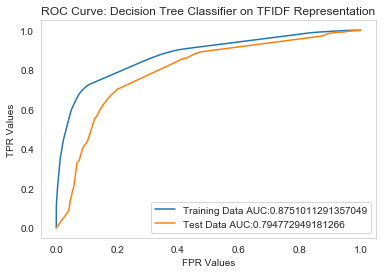

In [119]:
import matplotlib.pyplot as plt

plt.plot(train_fpr2,train_tpr2,label ='Training Data AUC:' + str(auc(train_fpr2,train_tpr2)))
plt.plot(test_fpr2,test_tpr2,label = 'Test Data AUC:' + str(auc(test_fpr2,test_tpr2)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Decision Tree Classifier on TFIDF Representation')

plt.grid(False)
plt.show()

In [86]:
Y_Train_pred2 = TFIDF_Test.predict_proba(X_DTTrain_TFIDF)[:,1]
Y_Test_pred2 = TFIDF_Test.predict_proba(X_DTTest_TFIDF)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6473521649084408
Threshold for Maximum Value of tpr*(1-fpr) : 0.441


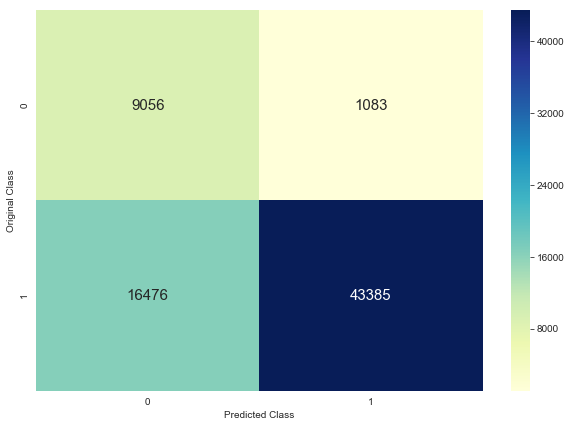

In [87]:
TFIDF_Train = confusion_matrix(Y_DTTrain,matrixpredict(Y_Train_pred2,threshold,train_tpr2,train_fpr2))
plottrainmatrix(TFIDF_Train)

Accuracy on the Training Data => (43385+9056)/70000 = 74.91%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.5620953749130144
Threshold for Maximum Value of tpr*(1-fpr) : 0.438


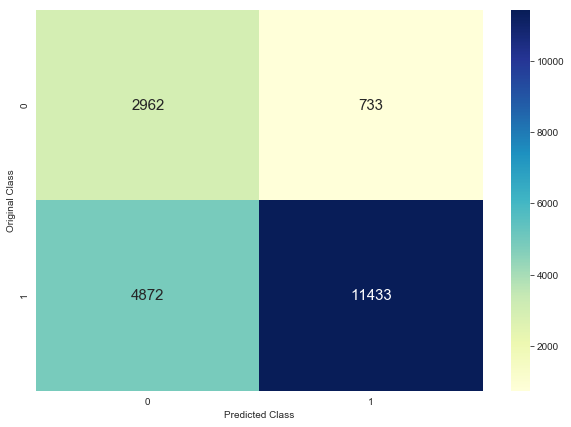

In [88]:
TFIDF_Test = confusion_matrix(Y_DTTest,matrixpredict(Y_Test_pred2,threshold,test_tpr2,test_fpr2))
plottestmatrix(TFIDF_Test)

Accuracy on the Test Data => (11433+2962)/20000 = 71.97%

# [5.2.1] Top 20 Important Features with Decision Tree Implementation & TFIDF Featurization :-

In [91]:
TFIDF_feature_names = tf_idf_vect.get_feature_names()
TFIDF_feature_importances = TFIDF_Test.feature_importances_
TFIDF_feature_importances_sorted = np.argsort(TFIDF_feature_importances)
TFIDF_feature_importances_reverse = np.flip(TFIDF_feature_importances_sorted)

In [159]:
print("The Top 20 Important Features with TFIDF Featurization and their corresponding feature importances" 
       "are as follows:")
print("="*100)
for i in TFIDF_feature_importances_reverse[:20]:
    print(TFIDF_feature_names[i],"\t", '--->',np.round(TFIDF_feature_importances[i],3))

The Top 20 Important Features with TFIDF Featurization and their corresponding feature importancesare as follows:
not 	 ---> 0.155
great 	 ---> 0.104
best 	 ---> 0.051
delicious 	 ---> 0.049
love 	 ---> 0.038
perfect 	 ---> 0.032
good 	 ---> 0.03
loves 	 ---> 0.028
bad 	 ---> 0.026
disappointed 	 ---> 0.024
nice 	 ---> 0.021
wonderful 	 ---> 0.017
excellent 	 ---> 0.017
favorite 	 ---> 0.016
thought 	 ---> 0.014
easy 	 ---> 0.013
awful 	 ---> 0.01
unfortunately 	 ---> 0.009
reviews 	 ---> 0.009
not great 	 ---> 0.009


# [5.2.2] Graphviz visualization of Decision Tree on TFIDF Featurization :-

In [94]:
from sklearn import tree
TFIDF_tree = tree.export_graphviz(decision_tree=TFIDF_Test,max_depth=3,feature_names = TFIDF_feature_names,
                               filled = True)

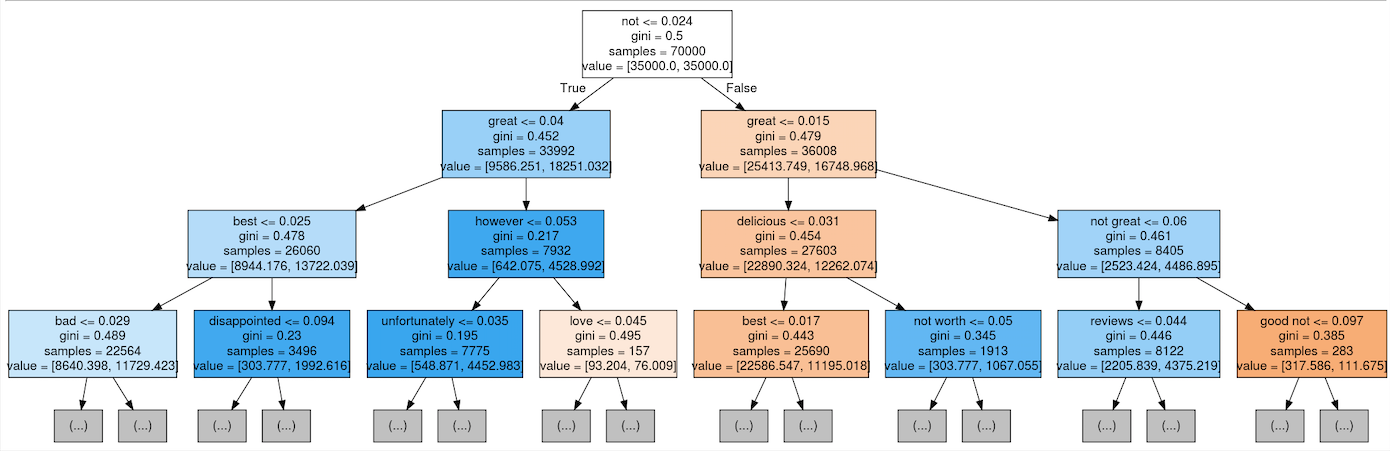

In [95]:
from IPython.display import Image
Image(filename='TFIDF_DT_filled.png')

# [5.3] SET 3 : Applying Decision Trees on Avg W2V :-

# Converting Reviews into Numerical Vectors using W2V vectors :-

In [96]:
list_of_sentence_Train =[]

for sentence in X_DTTrain:
    list_of_sentence_Train.append(sentence.split())

In [97]:
w2v_model=Word2Vec(list_of_sentence_Train,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("Number of words that occur a minimum 5 times :",len(w2v_words))
print("Some of the sample words are as follows: ", w2v_words[0:50])

Number of words that occur a minimum 5 times : 15838
Some of the sample words are as follows:  ['witty', 'little', 'book', 'makes', 'son', 'laugh', 'loud', 'car', 'driving', 'along', 'always', 'sing', 'refrain', 'learned', 'india', 'roses', 'love', 'new', 'words', 'introduces', 'classic', 'willing', 'bet', 'still', 'able', 'memory', 'college', 'remember', 'seeing', 'show', 'television', 'years', 'ago', 'child', 'sister', 'later', 'bought', 'day', 'thirty', 'something', 'used', 'series', 'books', 'songs', 'student', 'teaching', 'turned', 'whole', 'school', 'purchasing']


# Converting the Train Data Text :-

In [98]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_Train): # for each review/sentence for Training Dataset
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
sent_vectors_train = np.array(sent_vectors_train)
print(sent_vectors_train.shape)
print(sent_vectors_train[0])

100%|██████████| 70000/70000 [03:33<00:00, 327.71it/s]


(70000, 50)
[ 0.08374445  0.11358148 -0.6424285   0.16594547 -0.39580159 -0.21716521
  0.47262891 -0.09081476  0.29330332  0.33274209 -0.26223407 -0.1544759
  0.34929812  0.4287227  -0.02432394 -0.15540102  0.03349705  0.13095669
  0.26310493 -0.12339989 -0.03462045  0.31852649  0.42437512  0.57575718
  0.01906831 -0.10361083 -0.14755479 -0.18972265 -0.01085083  0.37595197
  0.22245147  0.14201182 -0.16854957  0.24117232  0.08469833 -0.16936301
 -0.03763765 -0.120778   -0.15587337 -0.05331916 -0.00095392  0.65585412
  0.23179963  0.34926485  0.22673576  0.07569735 -0.09777285  0.18406437
 -0.04635285  0.00166602]


# Converting the CV Data Text :- 

In [99]:
list_of_sentence_CV=[]

for sentence in X_DTCV:
    list_of_sentence_CV.append(sentence.split())

In [100]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_CV): # for each review/sentence in the CV Dataset.
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
sent_vectors_cv = np.array(sent_vectors_cv)
print(sent_vectors_cv.shape)
print(sent_vectors_cv[0])

100%|██████████| 10000/10000 [00:39<00:00, 337.10it/s]

(10000, 50)
[-0.47151479  0.73292572 -1.17230538 -0.95917967  0.16429216 -0.26138154
  0.0709977   0.18353182  1.33657234 -0.19855433 -0.68216277  0.56530448
 -0.17059103 -0.22029708  1.04768221 -0.3022164   0.5177164  -0.28265206
 -0.22390601  0.05136999 -0.15793241  0.10684319  1.2002637   0.47628892
  0.14220972  0.09045629 -0.36286917 -0.46014813 -0.09175275 -0.13922263
 -0.21393081  0.01136041 -0.44154121 -0.7144757  -0.57291803  1.06928191
  0.98161294 -0.39739939 -0.83762413 -1.07666478  1.0026014   0.11726452
 -0.03397764 -0.16374966  0.80529435  0.75766442 -0.59692761  0.07479387
 -0.0576688   0.3231994 ]


# Converting the Test Dataset :- 

In [101]:
list_of_sentence_Test=[]

for sentence in X_DTTest:
    list_of_sentence_Test.append(sentence.split())

In [102]:
# average Word2Vec
# compute average word2vec for each review.

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentence_Test): # for each review/sentence in the Test Dataset
    sent_vec = np.zeros(50) 
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
sent_vectors_test = np.array(sent_vectors_test)
print(sent_vectors_test.shape)
print(sent_vectors_test[0])

100%|██████████| 20000/20000 [01:18<00:00, 255.44it/s]


(20000, 50)
[ 0.41770288  0.50655313 -0.22420099 -0.03307324 -0.47707725 -0.32726287
  0.35200297 -0.11341446 -0.07472366  0.02816265 -0.0302562   0.07282364
  0.29646624 -0.22758231 -0.37472965 -0.46324453 -0.06229151  0.11658915
  0.21160062 -0.69033039  0.05002348  0.040887    0.47897451  0.3765551
  0.65207949  0.03952411 -0.25902525  0.04207033 -0.46113494  0.54533383
  0.40216599 -0.12814072  0.09710253  0.11077926  0.09974643 -0.21735699
  0.1146471  -0.04855074 -0.45418426  0.17501483 -0.14482127  0.20568244
  0.10788081  0.05281569  0.01160476  0.11674235  0.21745085  0.07394882
 -0.00847296 -0.16166151]


In [103]:
print("Shapes before the Avg W2V Vectorization was carried out:")

print(X_DTTrain.shape,Y_DTTrain.shape)
print(X_DTCV.shape,Y_DTCV.shape)
print(X_DTTest.shape,Y_DTTest.shape)

print("="*100)

print("Shapes after the Avg W2V Vectorization was carried out:")

print(sent_vectors_train.shape,Y_DTTrain.shape)
print(sent_vectors_cv.shape,Y_DTCV.shape)
print(sent_vectors_test.shape,Y_DTTest.shape)

Shapes before the Avg W2V Vectorization was carried out:
(70000,) (70000,)
(10000,) (10000,)
(20000,) (20000,)
Shapes after the Avg W2V Vectorization was carried out:
(70000, 50) (70000,)
(10000, 50) (10000,)
(20000, 50) (20000,)


# Hyperparameter Tuning on the Avg W2V Representation :- 

Again, there is no need to carry out Standardization for Decision Tree Classification because we do 
not have any hyperplane in consideration over here unlike the other algorithms that we have encountered previously.

<b> <font color="black"> Calling the Different Functions to obtain the Train and CV Dataframes and Obtaining the Seaborn HeatMaps for them :- </font> </b>

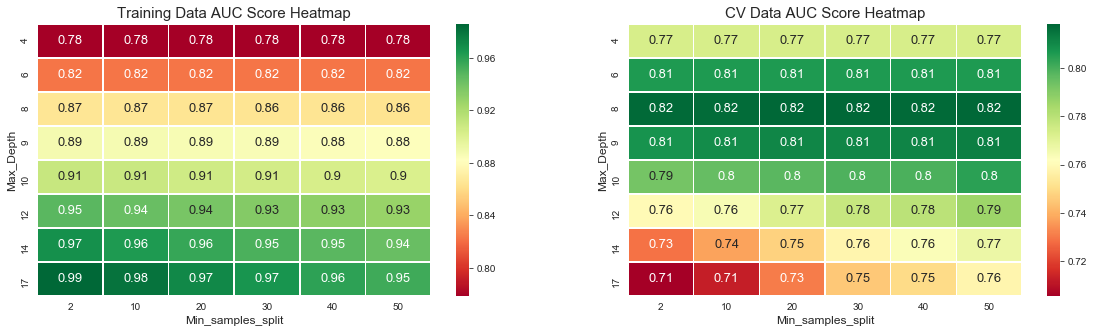

In [104]:
AW2V_Train_df = train_heatmap(sent_vectors_train,Y_DTTrain)
AW2V_CV_df = cv_heatmap(sent_vectors_train,Y_DTTrain,sent_vectors_cv,Y_DTCV)
plot_heatmaps(AW2V_Train_df,AW2V_CV_df)

With the Seaborn Heatmaps obtained, we see that :
* The maximum AUC Value on the CV Heatmap is 0.82, and the minimum AUC Value on the Train Heatmap for the same combination is 0.86. 
* Therefore the Best Combination of Max_Depth and Min_samples_split for the BOW Featurization is either of the following: 

Max_Depth=8.
Min_samples_split= 30 or 40 or 50.

* Therefore the best of these values is obtained by GridSearchCV below.

In [105]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

model3 = DecisionTreeClassifier(criterion='gini',splitter='best',class_weight='balanced')
    
DT_AW2V = GridSearchCV(model3,parameters,scoring='roc_auc',cv=10)
DT_AW2V.fit(sent_vectors_train,Y_DTTrain)
    
print(DT_AW2V.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Therefore, according to the Hyperparameter Tuning and obtaining the Best Hyperparameters of the model after carrying out Hyperparameter tuning via GridSearchCV, we obtain the following Best values :-
* max_depth = 8
* min_samples_split = 50

# Testing with the Test Data on the AW2V Representation:-

In [120]:
AW2V_Test = DecisionTreeClassifier(criterion='gini',splitter='best',class_weight='balanced',max_depth=8,
                                  min_samples_split=50)
AW2V_Test.fit(sent_vectors_train,Y_DTTrain)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Therefore here we are basically creating a model (to Test the model on the Test Data) by applying the Best values of the Hyperparameters hence obtained.

In [121]:
Y_DTTrain.shape

(70000,)

In [122]:
print(sent_vectors_train.shape)

(70000, 50)


In [123]:
print(Y_DTTest.shape)

(20000,)


In [124]:
print(sent_vectors_test.shape)

(20000, 50)


In [125]:
from sklearn.metrics import roc_curve, auc 

train_fpr3,train_tpr3,threshold = roc_curve(Y_DTTrain,AW2V_Test.predict_proba(sent_vectors_train)[:,1])
test_fpr3,test_tpr3,threshold = roc_curve(Y_DTTest,AW2V_Test.predict_proba(sent_vectors_test)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

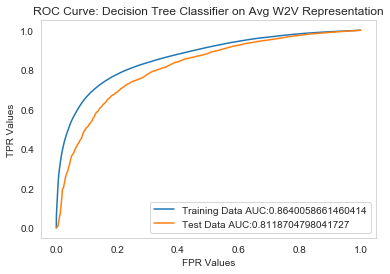

In [126]:
import matplotlib.pyplot as plt

plt.plot(train_fpr3,train_tpr3,label ='Training Data AUC:' + str(auc(train_fpr3,train_tpr3)))
plt.plot(test_fpr3,test_tpr3,label = 'Test Data AUC:' + str(auc(test_fpr3,test_tpr3)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Decision Tree Classifier on Avg W2V Representation')

plt.grid(False)
plt.show()

In [127]:
Y_Train_pred3 = AW2V_Test.predict_proba(sent_vectors_train)[:,1]
Y_Test_pred3 = AW2V_Test.predict_proba(sent_vectors_test)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.6245034780981965
Threshold for Maximum Value of tpr*(1-fpr) : 0.48


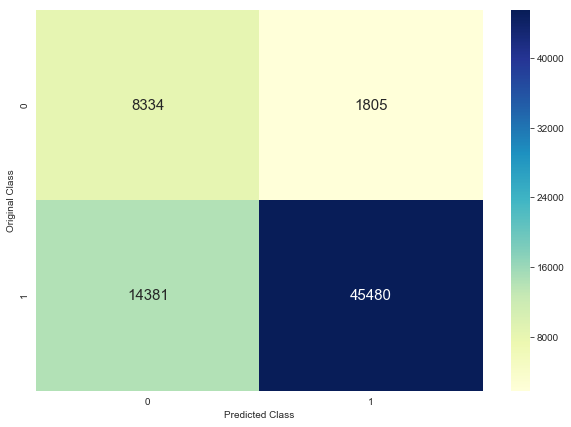

In [128]:
AW2V_Train = confusion_matrix(Y_DTTrain,matrixpredict(Y_Train_pred3,threshold,train_tpr3,train_fpr3))
plottrainmatrix(AW2V_Train)

Accuracy on the Training Data => (45480+8334)/70000 = 76.87%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.5579717487890471
Threshold for Maximum Value of tpr*(1-fpr) : 0.459


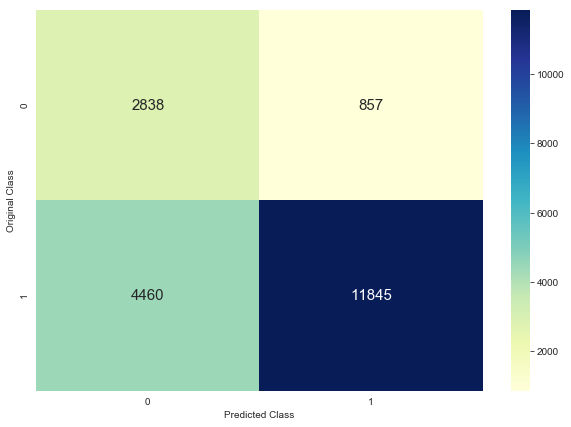

In [129]:
AW2V_Test = confusion_matrix(Y_DTTest,matrixpredict(Y_Test_pred3,threshold,test_tpr3,test_fpr3))
plottestmatrix(AW2V_Test)

Accuracy on the Test Data => (11845+2838)/20000 = 73.41%

# [5.4] SET 4 : Applying Decision Trees on TFIDF W2V :-

In [130]:
model_DT = TfidfVectorizer()
tf_idf_matrix = model_DT.fit_transform(X_DTTrain)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model_DT.get_feature_names(), list(model_DT.idf_)))

In [131]:
tf_idf_matrix.shape

(70000, 49207)

So basically tf_idf_matrix has learnt the vocabulary from X_Train and now we will apply the same on the Cross 
Validation as well as the Test Datasets.

# Converting Reviews into Numerical Vectors using W2V vectors :-

# Converting the Train Data Text :-

In [132]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_DT.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_DTTrain = []; # the tfidf-w2v for each sentence/review from Training Data is stored in this list
row=0;
for sent in tqdm(list_of_sentence_Train): # for each review/sentence in Training Data
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_DTTrain.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [50:38<00:00, 22.25it/s]  


In [133]:
tfidf_sent_vectors_DTTrain[1]

array([ 0.1304704 ,  0.57015529, -1.18922956,  0.13974138, -0.47373454,
        0.27974984,  0.419855  , -0.39407225,  0.21986594,  0.31392055,
       -0.1326052 , -0.27810041,  0.38461409,  0.12793856, -0.06008979,
        0.03570792, -0.21453964, -0.13601   ,  0.38189914,  0.12709805,
        0.20247222, -0.07358603,  0.25436161,  0.80897751,  0.00290538,
       -0.0022254 , -0.08372897, -0.29064979,  0.16774149,  0.26040704,
        0.34987317,  0.13962634, -0.52824507,  0.22459052,  0.1349742 ,
       -0.39915374, -0.25944629, -0.00642681,  0.09301739, -0.26557113,
        0.03964491,  0.33693007,  0.1457974 , -0.02743263,  0.03908711,
       -0.05679933,  0.26705852,  0.49281824, -0.33163641, -0.16492271])

# Converting the CV Data Text :-

In [134]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_DT.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_DTCV = []; # the tfidf-w2v for each sentence/review from the CV Dataset is stored in this list
row=0;
for sent in tqdm(list_of_sentence_CV): # for each review/sentence in the Cross Validation Dataset 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_DTCV.append(sent_vec)
    row += 1

100%|██████████| 10000/10000 [07:10<00:00, 23.24it/s]


# Converting the Test Data Text :-

In [135]:
# TF-IDF weighted Word2Vec
tfidf_feat = model_DT.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_DTTest = []; # the tfidf-w2v for each sentence/review from the Test Dataset is stored in this list
row=0;
for sent in tqdm(list_of_sentence_Test): # for each review/sentence in the Test Dataset 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_DTTest.append(sent_vec)
    row += 1

100%|██████████| 20000/20000 [17:55<00:00, 18.60it/s]


# Hyperparameter Tuning on the TFIDF W2V Representation :- 

Again, there is no need to carry out Standardization for Decision Tree Classification because we do 
not have any hyperplane in consideration over here unlike the other algorithms that we have encountered previously.

<b> <font color="black"> Calling the Different Functions to obtain the Train and CV Dataframes and Obtaining the Seaborn HeatMaps for them :- </font> </b>

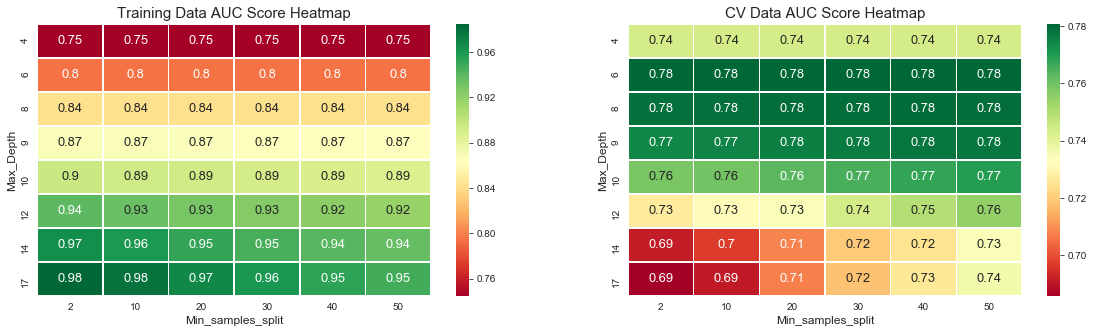

In [136]:
TFIDFW2V_Train_df = train_heatmap(tfidf_sent_vectors_DTTrain,Y_DTTrain)
TFIDFW2V_CV_df = cv_heatmap(tfidf_sent_vectors_DTTrain,Y_DTTrain,tfidf_sent_vectors_DTCV,Y_DTCV)
plot_heatmaps(TFIDFW2V_Train_df,TFIDFW2V_CV_df)

With the Seaborn Heatmaps obtained, we see that :
* The maximum AUC Value on the CV Heatmap is 0.78, and the minimum AUC Value on the Train Heatmap for the same combination is 0.84. 
* Therefore the Best Combination of Max_Depth and Min_samples_split for the BOW Featurization is either of the following: 

Max_Depth=8.
Min_samples_split= 30 or 40 or 50.

* Therefore the best of these values is obtained by GridSearchCV below.

In [137]:
warnings.filterwarnings('ignore')

#Carrying out 10-fold Cross Validation. class_weight is taken as 'balanced' since the data that we originally had
#was an Imbalanced Real World Dataset.

model4 = DecisionTreeClassifier(criterion='gini',splitter='best',class_weight='balanced')
    
DT_TFIDFW2V = GridSearchCV(model4,parameters,scoring='roc_auc',cv=10)
DT_TFIDFW2V.fit(tfidf_sent_vectors_DTTrain,Y_DTTrain)
    
print(DT_TFIDFW2V.best_estimator_)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=40,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Therefore, according to the Hyperparameter Tuning and obtaining the Best Hyperparameters of the model after carrying out Hyperparameter tuning via GridSearchCV, we obtain the following Best values :-
* max_depth = 8
* min_samples_split = 40

# Testing with the Test Data on the TFIDF W2V Representation:-

In [138]:
TFIDFW2V_Test = DecisionTreeClassifier(criterion='gini',splitter='best',class_weight='balanced',max_depth=8,
                                  min_samples_split=40)
TFIDFW2V_Test.fit(tfidf_sent_vectors_DTTrain,Y_DTTrain)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=40,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Therefore here we are basically creating a model (to Test the model on the Test Data) by applying the Best values of the Hyperparameters hence obtained.

In [139]:
from sklearn.metrics import roc_curve, auc 

train_fpr4,train_tpr4,threshold = roc_curve(Y_DTTrain,TFIDFW2V_Test.predict_proba(tfidf_sent_vectors_DTTrain)[:,1])
test_fpr4,test_tpr4,threshold = roc_curve(Y_DTTest,TFIDFW2V_Test.predict_proba(tfidf_sent_vectors_DTTest)[:,1])

Plotting the graph between the FPR Values as well as the TPR values for the Training Data as well as the Test data
we obtain the ROC Curve as follows:

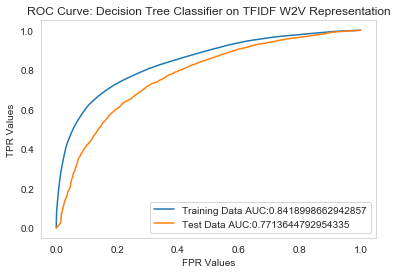

In [140]:
import matplotlib.pyplot as plt

plt.plot(train_fpr4,train_tpr4,label ='Training Data AUC:' + str(auc(train_fpr4,train_tpr4)))
plt.plot(test_fpr4,test_tpr4,label = 'Test Data AUC:' + str(auc(test_fpr4,test_tpr4)))
plt.legend()

plt.xlabel('FPR Values')
plt.ylabel('TPR Values')
plt.title('ROC Curve: Decision Tree Classifier on TFIDF W2V Representation')

plt.grid(False)
plt.show()

In [141]:
Y_Train_pred4 = TFIDFW2V_Test.predict_proba(tfidf_sent_vectors_DTTrain)[:,1]
Y_Test_pred4 = TFIDFW2V_Test.predict_proba(tfidf_sent_vectors_DTTest)[:,1]

<b> <font color="black"> Calling the Different Functions and Obtaining Confusion Matrices for the Ideal
Threshold Value:- </font> </b>

-------------------- Training Confusion Matrix --------------------
 
The Training Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.585135819110571
Threshold for Maximum Value of tpr*(1-fpr) : 0.475


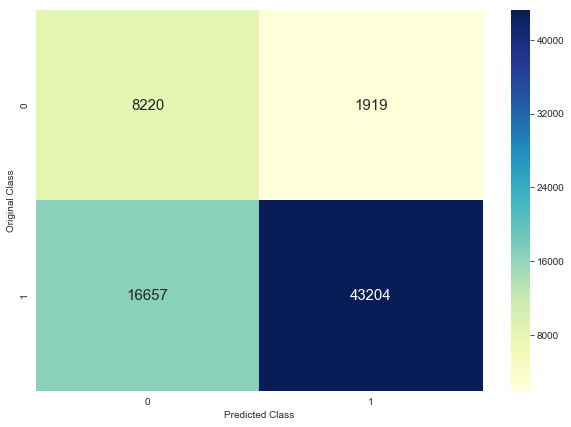

In [142]:
TFIDFW2V_Train = confusion_matrix(Y_DTTrain,matrixpredict(Y_Train_pred4,threshold,train_tpr4,train_fpr4))
plottrainmatrix(TFIDFW2V_Train)

Accuracy on the Training Data => (44976+8216)/70000 = 73.46%

The Test Data Confusion Matrix will look as follows by calling the user defined functions matrixpredict() and 
plottestmatrix() that were defined previously:

-------------------- Test Data Confusion Matrix --------------------
 
The Test Data Confusion Matrix is as follows:
 
The maximum value of tpr*(1-fpr) : 0.5024841828158176
Threshold for Maximum Value of tpr*(1-fpr) : 0.431


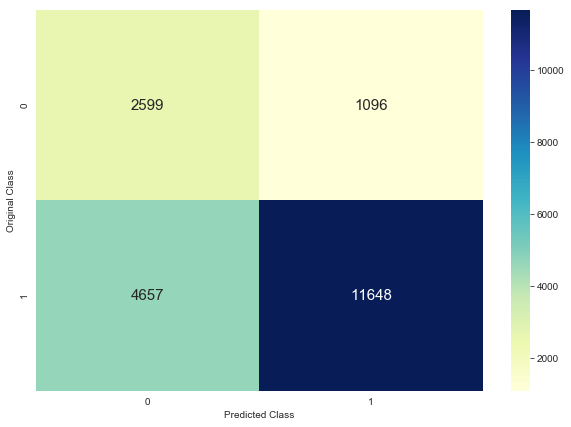

In [143]:
TFIDFW2V_Test = confusion_matrix(Y_DTTest,matrixpredict(Y_Test_pred4,threshold,test_tpr4,test_fpr4))
plottestmatrix(TFIDFW2V_Test)

Accuracy on the Test Data => (11983+2643)/20000 = 71.23%

# [6] Conclusions

In [160]:
from prettytable import PrettyTable

In [163]:
a=PrettyTable()
a.field_names=["S No.","Top 20 Important Features","Weight"]

In [164]:
print("Top 20 Most Important Features with Decision Trees & BOW Featurization:")
print(" "*100)

a.add_row(["1","not","0.174"])
a.add_row(["2","great","0.103"])
a.add_row(["3","best","0.054"])
a.add_row(["4","delicious","0.049"])
a.add_row(["5","love","0.035"])
a.add_row(["6","perfect","0.032"])
a.add_row(["7","good","0.029"])
a.add_row(["8","loves","0.028"])
a.add_row(["9","bad","0.024"])
a.add_row(["10","disappointed","0.019"])
a.add_row(["11","nice","0.018"])
a.add_row(["12","favorite","0.017"])
a.add_row(["13","excellent","0.015"])
a.add_row(["14","wonderful","0.015"])
a.add_row(["15","unfortunately","0.014"])
a.add_row(["16","easy","0.013"])
a.add_row(["17","thought","0.012"])
a.add_row(["18","money","0.011"])
a.add_row(["19","highly","0.009"])
a.add_row(["20","awful","0.008"])

print(a)

Top 20 Most Important Features with Decision Trees & BOW Featurization:
                                                                                                    
+-------+---------------------------+--------+
| S No. | Top 20 Important Features | Weight |
+-------+---------------------------+--------+
|   1   |            not            | 0.174  |
|   2   |           great           | 0.103  |
|   3   |            best           | 0.054  |
|   4   |         delicious         | 0.049  |
|   5   |            love           | 0.035  |
|   6   |          perfect          | 0.032  |
|   7   |            good           | 0.029  |
|   8   |           loves           | 0.028  |
|   9   |            bad            | 0.024  |
|   10  |        disappointed       | 0.019  |
|   11  |            nice           | 0.018  |
|   12  |          favorite         | 0.017  |
|   13  |         excellent         | 0.015  |
|   14  |         wonderful         | 0.015  |
|   15  |       unfortunatel

In [165]:
b=PrettyTable()
b.field_names=["S No.","Top 20 Important Features","Weight"]

In [166]:
print("Top 20 Most Important Features with Decision Trees & TFIDF Featurization:")
print(" "*100)

b.add_row(["1","not","0.155"])
b.add_row(["2","great","0.104"])
b.add_row(["3","best","0.051"])
b.add_row(["4","delicious","0.049"])
b.add_row(["5","love","0.038"])
b.add_row(["6","perfect","0.032"])
b.add_row(["7","good","0.03"])
b.add_row(["8","loves","0.028"])
b.add_row(["9","bad","0.026"])
b.add_row(["10","disappointed","0.024"])
b.add_row(["11","nice","0.021"])
b.add_row(["12","wonderful","0.017"])
b.add_row(["13","excellent","0.017"])
b.add_row(["14","favorite","0.016"])
b.add_row(["15","thought","0.014"])
b.add_row(["16","easy","0.013"])
b.add_row(["17","awful","0.01"])
b.add_row(["18","unfortunately","0.009"])
b.add_row(["19","reviews","0.009"])
b.add_row(["20","not great","0.009"])

print(b)

Top 20 Most Important Features with Decision Trees & TFIDF Featurization:
                                                                                                    
+-------+---------------------------+--------+
| S No. | Top 20 Important Features | Weight |
+-------+---------------------------+--------+
|   1   |            not            | 0.155  |
|   2   |           great           | 0.104  |
|   3   |            best           | 0.051  |
|   4   |         delicious         | 0.049  |
|   5   |            love           | 0.038  |
|   6   |          perfect          | 0.032  |
|   7   |            good           |  0.03  |
|   8   |           loves           | 0.028  |
|   9   |            bad            | 0.026  |
|   10  |        disappointed       | 0.024  |
|   11  |            nice           | 0.021  |
|   12  |         wonderful         | 0.017  |
|   13  |         excellent         | 0.017  |
|   14  |          favorite         | 0.016  |
|   15  |          thought

In [167]:
c = PrettyTable()
c.field_names=["Model","Ideal Max_Depth","Ideal Min_Samples_Split","Ideal Threshold Test Accuracy",
               "Test AUC Score"]

In [168]:
print("Performance on Test Data using different Featurizations using Decision Trees:")
print(" "*100)

c.add_row(["BOW","17","50","71.93%","0.79"])
c.add_row(["TFIDF","17","50","71.97%","0.79"])
c.add_row(["Avg W2V","8","50","73.41%","0.81"])
c.add_row(["TFIDF W2V","8","40","71.23%","0.77"])

print(c)

Performance on Test Data using different Featurizations using Decision Trees:
                                                                                                    
+-----------+-----------------+-------------------------+-------------------------------+----------------+
|   Model   | Ideal Max_Depth | Ideal Min_Samples_Split | Ideal Threshold Test Accuracy | Test AUC Score |
+-----------+-----------------+-------------------------+-------------------------------+----------------+
|    BOW    |        17       |            50           |             71.93%            |      0.79      |
|   TFIDF   |        17       |            50           |             71.97%            |      0.79      |
|  Avg W2V  |        8        |            50           |             73.41%            |      0.81      |
| TFIDF W2V |        8        |            40           |             71.23%            |      0.77      |
+-----------+-----------------+-------------------------+---------------

<b> <font color="black"> Following are some Conclusions from the observations:- </font> </b>

* As far as the "Decision Tree" performance for the different featurizations is concerned, Avg W2V is
  the best across all the models since it has the highest Test Accuracy and Test AUC. This is followed by the TFIDF model.
* Overall, "Decision Tree" is not a very good model in this scenario as compared to the models that we saw previously because the "Ideal Threshold Test Accuracy" for all the 4 Featurizations is only around 72 % which is not very high.